# Unsupervised Machine Learning Project

### David Wullimann

Performed UMAP analysis of my T-cell experiment to perform dimensional reduction and get an overview of the data.

UMAP library: https://umap-learn.readthedocs.io/en/latest/index.html

## Import libraries 

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [840]:
import umap

In [35]:
pd.options.display.min_rows = 100

## Read data and layouts  

In [36]:
## Read layouts that will be used to map well id to antigen and time points

layout96 = pd.read_excel('Layouts.xlsx', sheet_name='Layout96')
layout72 = pd.read_excel('Layouts.xlsx', sheet_name='Layout72')

In [499]:
#### This loop reads all .xls files ####

### Generates two dictionaries 
### dfs_96 for the groups A and C (96 samples, 7 time points)
### dfs_72 for the groups B, D, E (72 samples, 5 time points)

folders1 = ['A1', 'A2', 'C']
folders2 = ['B1', 'B2', 'D', 'E']

path = 'C:\\Users\\davwul\\OneDrive - KI.SE\\Skrivbordet\\Full screen T-cell experiments\\2.T-cell and AIM Gate export\\'

dfs_96 = {}

for i in folders1:
    
    n_path = path + i
    
    for filename in os.listdir(n_path):
        
        if filename.endswith(".xls"):
            
            file_path = os.path.join(n_path, filename)
            
            df_name = os.path.splitext(filename)[0] + "_df"
            dfs_96[df_name] = pd.read_excel(file_path)
            
dfs_72 = {}
            
for i in folders2:
    
    n_path = path + i
    
    for filename in os.listdir(n_path):
        
        if filename.endswith(".xls"):
            
            file_path = os.path.join(n_path, filename)
            
            df_name = os.path.splitext(filename)[0] + "_df"
            dfs_72[df_name] = pd.read_excel(file_path)

In [500]:
# Check whether data frames have 'WELL ID' column
# If not: Add it 

for key, df in dfs_96.items():
    if 'WELL ID' in df.columns:
        print(f"DataFrame '{key}' contains the column 'WELL ID'.")
    else:
        print(f"DataFrame '{key}' does not contain the column 'WELL ID'.")
        df['WELL ID'] = df['Sample'].str.extract(r'_([A-H]1[0-2]|[A-H][1-9]|10|11|12)')

DataFrame 'Table_A1-04_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-06_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-08_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-11_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-13_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-14_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-15_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-16_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-20_df' does not contain the column 'WELL ID'.
DataFrame 'Table_A1-25_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-29_df' contains the column 'WELL ID'.
DataFrame 'Table_A1-30_df' does not contain the column 'WELL ID'.
DataFrame 'Table_A2-01_df' contains the column 'WELL ID'.
DataFrame 'Table_A2-02_df' contains the column 'WELL ID'.
DataFrame 'Table_A2-03_df' contains the column 'WELL ID'.
DataFrame 'Table_A2-05_df' contains the column 'WELL ID'.
DataFrame 'Table_A2-07_df' contains the column 'WELL ID'

In [501]:
# Fix 'Table_A1-30_df'

dfs_96['Table_A1-30_df'].drop(columns = 'WELL ID', inplace= True)
dfs_96['Table_A1-30_df'].rename(columns = {'Well ID': 'WellID'}, inplace= True)

In [502]:
# Fix 'Table_A1-20_df'

dfs_96['Table_A1-20_df']['WELL ID'] =  dfs_96['Table_A1-20_df']['WELL ID'].apply(lambda x: x[0] + '0' + x[1] if len(x) == 2 and x[1].isdigit() and int(x[1]) < 10 else x)

In [503]:
# Change name of column WELL ID to WellID to match Layout

for key, df in dfs_96.items():
    if 'WELL ID' in df.columns:
        # Rename the column
        df.rename(columns={'WELL ID': 'WellID'}, inplace=True)
        

for key, df in dfs_72.items():
    if 'WELL ID' in df.columns:
        # Rename the column
        df.rename(columns={'WELL ID': 'WellID'}, inplace=True)

In [ ]:
# Merge the dataframes with Layout to map WellID

for key, df in dfs_96.items():
    dfs_96[key] = df.merge(layout96[['WellID', 'Antigen', 'TimePoint']])
    
for key, df in dfs_72.items():
    dfs_72[key] = df.merge(layout72[['WellID', 'Antigen', 'TimePoint']])

In [508]:
# Get a list of all DataFrames in dfs_72
dfs_list = list(dfs_72.values())

# Concatenate all DataFrames along rows
df1 = pd.concat(dfs_list, axis=0, ignore_index=True)
dfa = pd.concat(dfs_list, axis=0, ignore_index=True)

df1 = df1[~df1['Antigen'].isin(['NC', 'PC'])]
df1 = df1[df1['TimePoint'] != 'Reference']

dfa = dfa[dfa['TimePoint'] != 'Reference']

In [509]:
# Get a list of all DataFrames in dfs_72
dfs_list = list(dfs_96.values())

# Concatenate all DataFrames along rows
df2 = pd.concat(dfs_list, axis=0, ignore_index=True)
dfb = pd.concat(dfs_list, axis=0, ignore_index=True)

df2 = df2[~df2['Antigen'].isin(['NC', 'PC'])]
df2 = df2[df2['TimePoint'] != 'Reference']

dfb = dfb[dfb['TimePoint'] != 'Reference']

In [511]:
## Create separate list of columns for Count and Freq populations

cols = list(df1.columns)

freq_list = []
count_list = []

for i in cols:
    
    if i.endswith("Freq"):
        freq_list.append(i)
    if i.endswith("Count"):
        count_list.append(i)

In [ ]:
## Continue analysis with Freq population

In [512]:
needed_cols = ['PATIENT ID', 'TimePoint', 'Antigen']
freq_cols = needed_cols + freq_list

In [513]:
### Create separate data frames for further analysis
## one df will be used to remove certain rows and one will be kept as is

ndfa = dfa.reindex(columns=freq_cols)
ndf1 = df1.reindex(columns=freq_cols)

ndf1['Group'] = ndf1['PATIENT ID'].str.extract(r'^([^-\s]+)')
ndfa['Group'] = ndfa['PATIENT ID'].str.extract(r'^([^-\s]+)')

In [514]:
ndfb = dfb.reindex(columns=freq_cols)
ndf2 = df2.reindex(columns=freq_cols)

ndf2['Group'] = ndf2['PATIENT ID'].str.extract(r'^([^-\s]+)')
ndfb['Group'] = ndfb['PATIENT ID'].str.extract(r'^([^-\s]+)')

In [515]:
## Merge the data frames

df = pd.concat([ndf1, ndf2], ignore_index=True)
dfnc = pd.concat([ndfa, ndfb], ignore_index=True)

In [516]:
## Change order of columns

cols =['PATIENT ID', 'Group','TimePoint', 'Antigen', 'Lymphocytes_Freq',
       'SingleCells1_Freq', 'SingleCells2_Freq', 'CD3+_Freq', 'CD4+_Freq',
       'CD4+CD38+_Freq', 'CD4+CD38+CD69+CD40L+_Freq', 'CD4+CD38+TCM_Freq',
       'CD4+CD38+TN_Freq', 'CD4+CD38+TEMRA_Freq', 'CD4+CD38+TEM_Freq',
       'CD4+CXCR5+_Freq', 'CD4+CXCR5+CD69+CD40L+_Freq', 'CD4+CD69+CD40L+_Freq',
       'CD69+CD40L+CD4+CXCR5+_Freq', 'CD4+CD69+CD40L+TCM_Freq',
       'CD4+CD69+CD40L+TN_Freq', 'CD4+CD69+CD40L+TEMRA_Freq',
       'CD4+CD69+CD40L+TEM_Freq', 'CD4+Memory_Freq',
       'CD4+MemoryCD69+CD40L+_Freq', 'CD4+TCM_Freq', 'CD4+TN_Freq',
       'CD4+TEMRA_Freq', 'CD4+TEM_Freq', 'CD8+Freq', 'CD8+CD38+_Freq',
       'CD8+CX3CR1+_Freq', 'CD8+CX3CR1+CD69+41BB+_Freq', 'CD8+CXCR5+_Freq',
       'CD8+CXCR5+CD69+41BB+_Freq', 'CD8+CD38+CX3CR1+_Freq',
       'CD8+CD69+41BB+_Freq', 'CD8+CD69+41BB+TCM_Freq',
       'CD8+CD69+41BB+TN_Freq', 'CD8+CD69+41BB+TEMRA_Freq',
       'CD8+CD69+41BB+TEM_Freq', 'CD8+Memory_Freq',
       'CD8+MemoryCD69+41BB+_Freq', 'CD8+TCM_Freq', 'CD8+TN_Freq',
       'CD8+TEMRA_Freq', 'CD8+TEM_Freq']

df = df.reindex(columns=cols)
dfnc = dfnc.reindex(columns= cols)

In [517]:
####

In [550]:
# Remove A1-08 from dfs_96 
# Remove E-05, E-08, E-12, E-15, E-21

remove_list = ['A1-08', 'E-05', 'E-08', 'E-12', 'E-12', 'E-21']
dfnc = dfnc[~dfnc['PATIENT ID'].isin(remove_list)]
df = df[~df['PATIENT ID'].isin(remove_list)]

## UMAP Projection:  PC and NC

In [1133]:
p = dfnc.loc[ (dfnc["Antigen"].isin(["PC", "NC"])) ]

p.loc[p["Antigen"] == "NC", "Antigen"] = 0
p.loc[p["Antigen"] == "PC", "Antigen"] = 1

In [1134]:
X = p.select_dtypes("number")

In [1135]:
reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(825, 2)

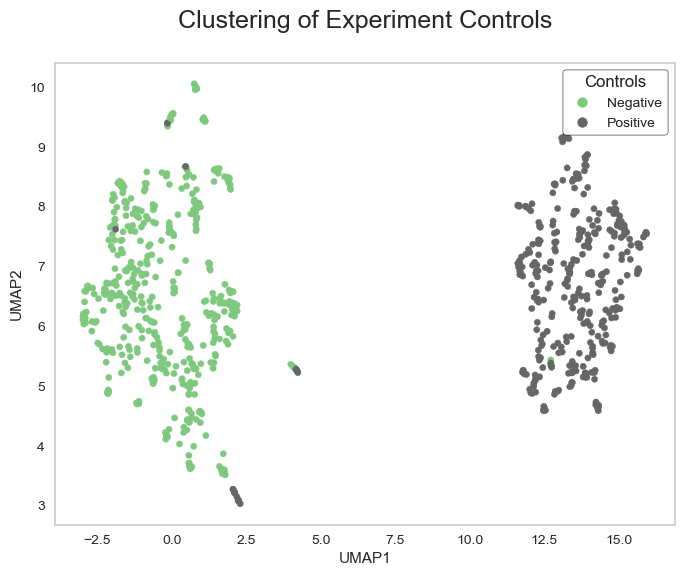

In [1136]:
fig, ax = plt.subplots(figsize= (8,6))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=p["Antigen"], cmap='Accent', s=20)

label_mapping = {0: "Negative", 1: "Positive"}

# Create legend with unique categories and corresponding colors
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper right", title="Controls", bbox_to_anchor=(1.0, 1.0),
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('Clustering of Experiment Controls\n', fontsize=18)
plt.grid(False)
plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_controls.png", dpi= 300)

## UMAP Projection: NC and Experiment

In [1124]:
o = dfnc.loc[dfnc["Antigen"].isin(["TBEV_E", "NC"])]

o.loc[o["Antigen"] == "NC", "Antigen"] = 0
o.loc[o["Antigen"] == "TBEV_E", "Antigen"] = 1

In [1125]:
cols = ['PATIENT ID', 'Group', 'TimePoint', 'Antigen', 'CD4+CXCR5+CD69+CD40L+_Freq',
       'CD4+CD69+CD40L+_Freq', 'CD69+CD40L+CD4+CXCR5+_Freq', 'CD4+Memory_Freq',
       'CD4+MemoryCD69+CD40L+_Freq', 'CD4+CD69+CD40L+TCM_Freq',
       'CD4+CD69+CD40L+TN_Freq', 'CD4+CD69+CD40L+TEMRA_Freq',
       'CD4+CD69+CD40L+TEM_Freq', 'CD8+CX3CR1+CD69+41BB+_Freq', 'CD8+CXCR5+_Freq',
       'CD8+CXCR5+CD69+41BB+_Freq', 'CD8+CD38+CX3CR1+_Freq',
       'CD8+CD69+41BB+_Freq', 'CD8+CD69+41BB+TCM_Freq',
       'CD8+CD69+41BB+TN_Freq', 'CD8+CD69+41BB+TEMRA_Freq',
       'CD8+CD69+41BB+TEM_Freq', 'CD8+Memory_Freq',
       'CD8+MemoryCD69+41BB+_Freq', 'CD8+TCM_Freq', 'CD8+TN_Freq',
       'CD8+TEMRA_Freq', 'CD8+TEM_Freq']

In [1126]:
o = o.reindex(columns= cols)

In [1127]:
X = o.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(928, 2)

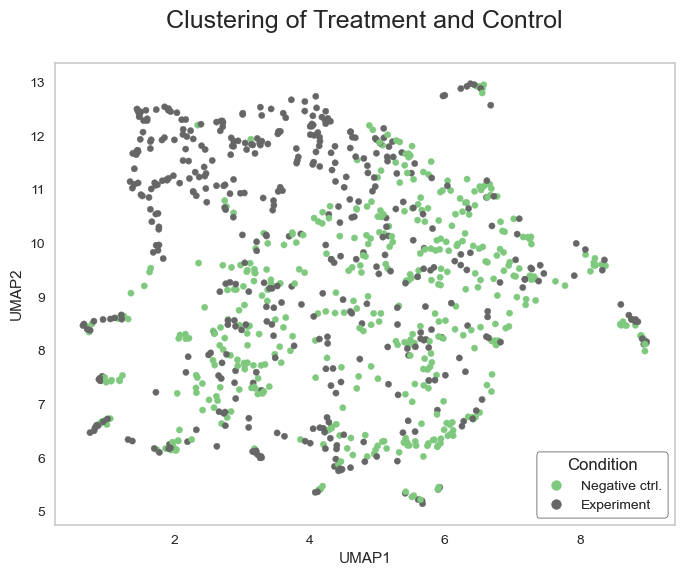

In [1128]:
fig, ax = plt.subplots(figsize= (8,6))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=o["Antigen"], cmap='Accent', s=20)

label_mapping = {0: "Negative ctrl.", 1: "Experiment"}

# Create legend with unique categories and corresponding colors
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="lower right", title="Condition",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('Clustering of Treatment and Control\n', fontsize=18)
plt.grid(False)
plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_nc_treatment.png", dpi= 300)

In [805]:
########

In [1129]:
j = dfnc.loc[ (dfnc["Antigen"].isin(["TBEV_E", "NC", "PC"])) ]

j.loc[j["Antigen"] == "NC", "Antigen"] = 0
j.loc[j["Antigen"] == "TBEV_E", "Antigen"] = 1
j.loc[j["Antigen"] == "PC", "Antigen"] = 2

In [1130]:
j = j.reindex(columns= cols)

In [1131]:
X = j.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(1288, 2)

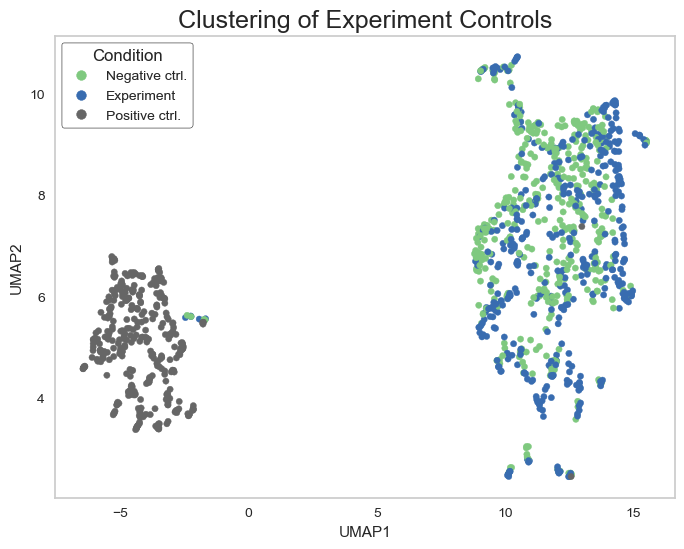

In [1132]:
fig, ax = plt.subplots(figsize= (8,6))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=j["Antigen"], cmap='Accent', s=20)

label_mapping = {0: "Negative ctrl.", 1: "Experiment", 2: "Positive ctrl."}

# Create legend with unique categories and corresponding colors
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper left", title="Condition",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('Clustering of Experiment Controls', fontsize=18)
plt.grid(False)
plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.show()

In [532]:
###########

# UMAP projection: TimePoints and Groups

In [914]:
h = df.loc[ (df["Antigen"].isin(["TBEV_E"])) ]

In [1137]:
cols = ['PATIENT ID', 'Group', 'TimePoint', 'Antigen', 'CD4+CXCR5+CD69+CD40L+_Freq',
       'CD4+CD69+CD40L+_Freq', 'CD69+CD40L+CD4+CXCR5+_Freq', 'CD4+Memory_Freq',
       'CD4+MemoryCD69+CD40L+_Freq', 'CD4+CD69+CD40L+TCM_Freq',
       'CD4+CD69+CD40L+TN_Freq', 'CD4+CD69+CD40L+TEMRA_Freq',
       'CD4+CD69+CD40L+TEM_Freq', 'CD8+CX3CR1+CD69+41BB+_Freq', 'CD8+CXCR5+_Freq',
       'CD8+CXCR5+CD69+41BB+_Freq', 'CD8+CD38+CX3CR1+_Freq',
       'CD8+CD69+41BB+_Freq', 'CD8+CD69+41BB+TCM_Freq',
       'CD8+CD69+41BB+TN_Freq', 'CD8+CD69+41BB+TEMRA_Freq',
       'CD8+CD69+41BB+TEM_Freq', 'CD8+Memory_Freq',
       'CD8+MemoryCD69+41BB+_Freq', 'CD8+TCM_Freq', 'CD8+TN_Freq',
       'CD8+TEMRA_Freq', 'CD8+TEM_Freq']

In [916]:
h = h.reindex(columns= cols)

In [917]:
h["Group"] = h["Group"].map({"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C": 4, "D": 5, "E": 6})

In [918]:
X = h.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(463, 2)

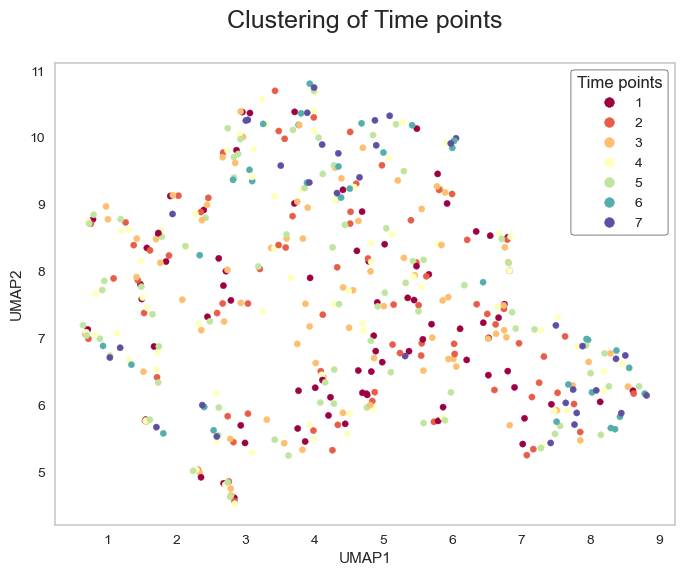

In [921]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=h["TimePoint"], cmap='Spectral', s=20)


ax.grid(False)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Time points",
                   frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('Clustering of Time points\n', fontsize=18)

plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_timepoints.png", dpi= 300)

In [1143]:
h = df.loc[ (df["Antigen"].isin(["TBEV_E", "TBEV_C"])) ]

In [1144]:
h = h.reindex(columns= cols)

In [1145]:
h = h.loc[h["Group"].isin(["A1", "A2"])]

In [1146]:
h = h.loc[h["TimePoint"].isin([1, 5, 6, 7])]

In [1147]:
h["Group"] = h["Group"].map({"A1": 0, "A2": 1})

In [1148]:
X = h.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(182, 2)

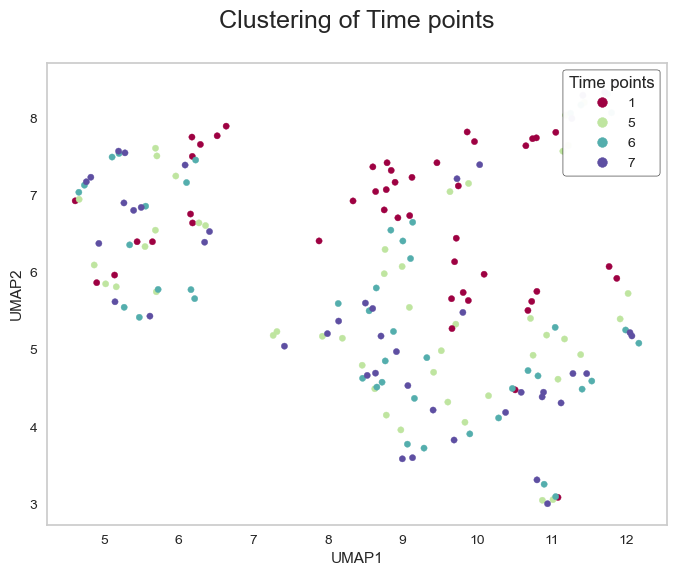

In [1149]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=h["TimePoint"], cmap='Spectral', s=20)


ax.grid(False)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Time points",
                   frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('Clustering of Time points\n', fontsize=18)

plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_timepoints.png", dpi= 300)

# UMAP by Group

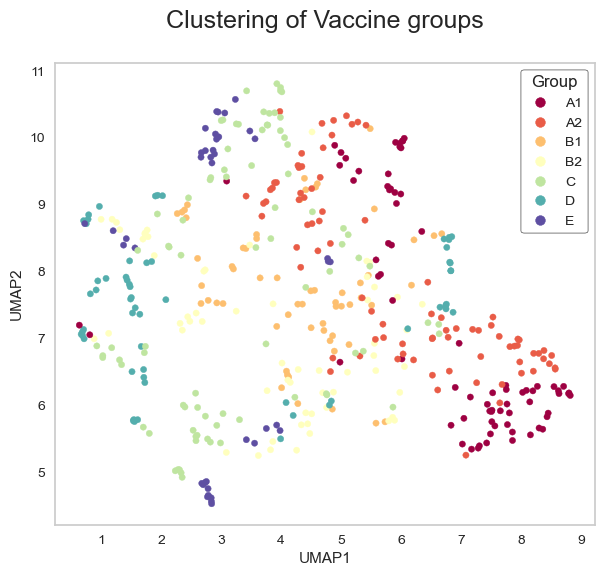

In [923]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=h["Group"], cmap='Spectral', s=20)

label_mapping = {0: "A1", 1: "A2", 2: "B1", 3: "B2", 4: "C", 5: "D", 6: "E"}

# Create legend with unique categories and corresponding colors
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper right", title="Group",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

# Move the legend to its own line
plt.subplots_adjust(right=0.8)
ax.grid(False)

plt.title('Clustering of Vaccine groups\n', fontsize=18)

plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_groups.png", dpi= 300)

In [ ]:
##################

In [1080]:
b = df.loc[ (df["Antigen"].isin(["TBEV_E", "YFV_E", "JEV_E"])) ]

In [1081]:
b = b.reindex(columns= cols)

In [1082]:
b1 = b.loc[ b["Group"].isin(["A1", "A2", "C"])]

In [1083]:
b2 = b.loc[ b["Group"].isin(["B1", "B2", "D", "E"])]

In [1084]:
b1["Group"] = b1["Group"].map( {"A1": 0, "A2": 1, "C": 2})
b2["Group"] = b2["Group"].map( {"B1": 0, "B2": 1, "D": 2, "E": 3})

C:\Users\davwul\AppData\Local\Temp\ipykernel_27452\2484925168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1["Group"] = b1["Group"].map( {"A1": 0, "A2": 1, "C": 2})
C:\Users\davwul\AppData\Local\Temp\ipykernel_27452\2484925168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b2["Group"] = b2["Group"].map( {"B1": 0, "B2": 1, "D": 2, "E": 3})


In [1085]:
X = b1.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(732, 2)

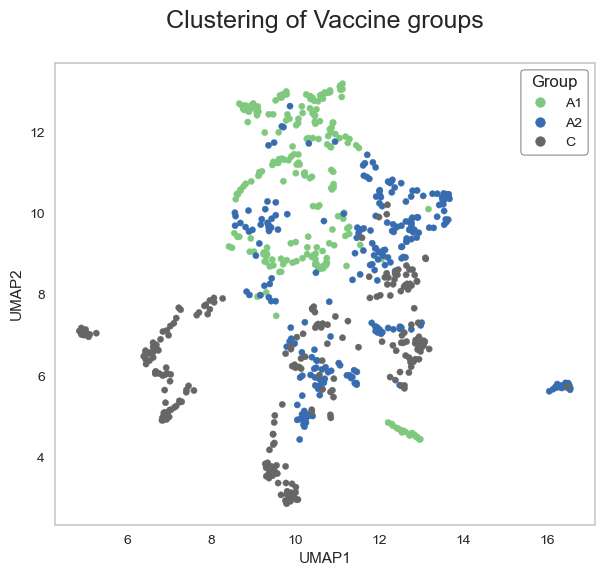

In [1087]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=b1["Group"], cmap='Accent', s=20)

label_mapping = {0: "A1", 1: "A2", 2: "C"}

legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper right", title="Group",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

# Move the legend to its own line
plt.subplots_adjust(right=0.8)
ax.grid(False)

plt.title('Clustering of Vaccine groups\n', fontsize=18)

plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_group1.png", dpi= 300)

In [1088]:
X = b2.select_dtypes("number")

reducer = umap.UMAP()

scaled_df = StandardScaler().fit_transform(X)

embedding = reducer.fit_transform(scaled_df)
embedding.shape

(660, 2)

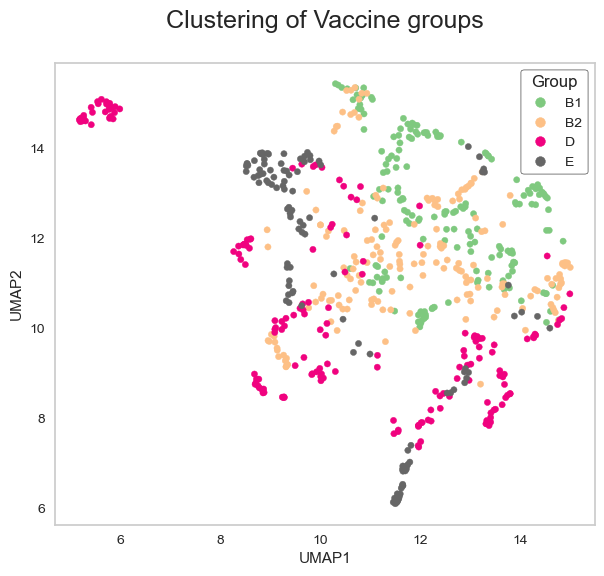

In [1090]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=b2["Group"], cmap='Accent', s=20)

label_mapping = {0: "B1", 1: "B2", 2: "D", 3: "E"}

legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper right", title="Group",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

# Move the legend to its own line
plt.subplots_adjust(right=0.8)
ax.grid(False)

plt.title('Clustering of Vaccine groups\n', fontsize=18)

plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_group2.png", dpi= 300)

In [ ]:
###################

# UMAP with Penguins Dataset

In [853]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins = penguins.dropna()

In [854]:
reducer = umap.UMAP()

In [871]:
penguins["species"] = penguins["species"].map({"Adelie":0, "Chinstrap":1, "Gentoo":2})

In [866]:
X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values

In [867]:
scaled_X = StandardScaler().fit_transform(X)

In [868]:
embedding = reducer.fit_transform(scaled_X)
embedding.shape

(333, 2)

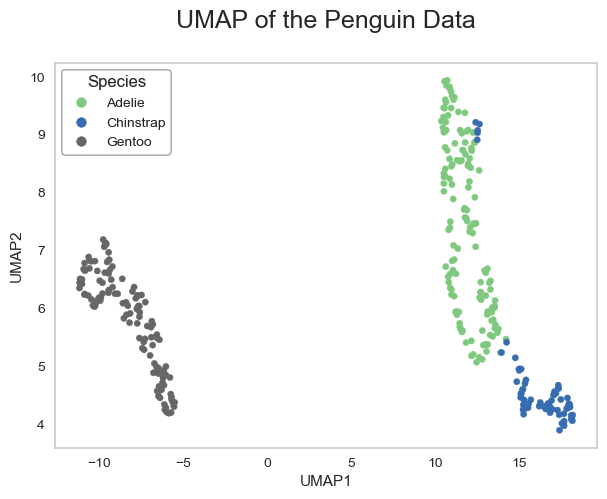

In [896]:
fig, ax = plt.subplots(figsize= (7,5))

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=penguins["species"], cmap='Accent', s=20)

 
label_mapping = {0: "Adelie", 1: "Chinstrap", 2: "Gentoo"}

# Create legend with unique categories and corresponding colors
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[label_mapping[key] for key in label_mapping.keys()], 
                    loc="upper left", title="Species",
                    frameon=True, edgecolor='black')

ax.add_artist(legend1)

plt.title('UMAP of the Penguin Data\n', fontsize=18)
plt.grid(False)
plt.ylabel("UMAP2")
plt.xlabel("UMAP1")

plt.savefig("umap_penguin.png", dpi= 300)

In [ ]:
####

In [1036]:
n = df[["Group", "Antigen", "TimePoint", 'CD4+CD69+CD40L+_Freq']]

In [1037]:
n1 = n.loc[ (n["TimePoint"].isin([5])) & (n["Group"].isin(['B1', 'B2', 'D', 'E']))]

In [1038]:
n2 = n.loc[ (n["TimePoint"].isin([7])) & (n["Group"].isin(['A1', 'A2', 'C',]))]

In [1039]:
n3 = pd.concat([n1, n2], axis=0)

In [1046]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [1059]:
sns.set_style("ticks")

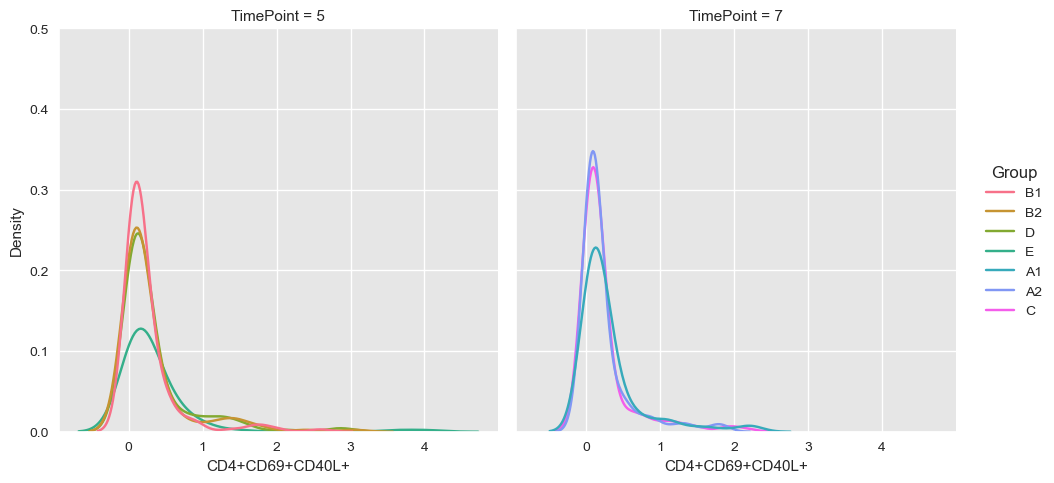

In [1047]:
g = sns.displot(data=n3, x='CD4+CD69+CD40L+_Freq', hue='Group', kind='kde', 
                col="TimePoint", height=5, aspect=1.0)

for ax in g.axes.flat:
    #ax.axvline(x=0, color='black', linestyle='dotted', linewidth=1.2)
    ax.set_ylim(0, 0.5)  # Set y-axis limits
    ax.set_xlabel("CD4+CD69+CD40L+")

# Show the plot
plt.show()
